Group 5: Raveel Tejani, Sam Young

# Lab 13: Bagging, Boosting and Photometric Redshift

In this notebook, we explore the powerful ensemble class of methods in sklearn. We use Random Forests, AdaBoost and GradientBoosting to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y). 

License: [BSD-3-clause](https://opensource.org/license/bsd-3-clause/)

Essentially, we try to reproduce/improve upon the results of [this paper](https://arxiv.org/abs/1903.08174), for which the data are public and available [here](http://d-scholarship.pitt.edu/36064/). 

To get an idea of what we are shooting for, we can look at a figure in the paper:

 ![Performance of photometric redshift reconstruction](Photoz_RF_CFHTLS_Deep.png)

In the figure above, $\sigma_{NMAD}$ is the normalized median absolute deviation of the residual vector, and $\eta$  is the fraction of outliers, defined as those objects for which (z_true - z_est)/(1+z_true) > 0.15. To be fair, we are working with DEEP2/3 data, so our range is slightly different.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

font = {'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 100

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

In [3]:
import astropy
from astropy.io import fits
#fits stands for Flexible Image Transport System; it's a format that allows one to store images and summary data

## Step 1: Data import and preparation

We can read the data into a data frame using pandas:

In [4]:
with fits.open('DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) #see https://numpy.org/devdocs/user/basics.byteswapping.html#changing-byte-ordering

1. How many features and examples are in the dataset?

In [5]:
df.head()

,objno_deep2,ra_deep2,dec_deep2,magb,magr,magi,pgal,sfd_ebv,class,subclass,objname,maskname,slitname,date,mjd,z_raw,zhelio,z_err,rchi2,dof,vdisp,vdisp_err,zquality,egsflags,comment,m_b,ub_0,ra_cfhtls,dec_cfhtls,u,g,r,i,i2,z,uerr,gerr,rerr,ierr,i2err,zerr,u_apercor,g_apercor,r_apercor,i_apercor,i2_apercor,z_apercor,uerr_aper,gerr_aper,rerr_aper,ierr_aper,i2err_aper,zerr_aper,uerr_apercor,gerr_apercor,rerr_apercor,ierr_apercor,i2err_apercor,zerr_apercor,r_radius_arcsec,u(sexflag),g(sexflag),r(sexflag),i(sexflag),i2(sexflag),z(sexflag),flag_cfhtls,cfhtls_source,ra_subaru,dec_subaru,y,yerr,y_apercor,yerr_aper,yerr_apercor,y(sexflag),y_radius_arcsec,subaru_source
0,11001673,213.868704,51.956445,23.487745,23.143082,22.582092,1.000000,0.010943,b'',b'',b'11001673',b'1101',b'000',b'2003-05-06',52765.457031,1.115297,1.115261,999.900024,0.630934,57.0,999.900024,999.900024,2,16777216,"b'bext, bcol, possible OII'",-999.000000,-999.0000,213.868620,51.956434,23.529039,23.393115,23.148170,22.854212,-99.0,22.162377,0.0678,0.0400,0.0382,0.0678,-99.0,0.0623,23.543491,23.430495,23.100311,22.768970,-99.0,22.223810,0.0542,0.0323,0.0279,0.0466,-99.0,0.0536,0.039631,0.041359,0.039777,0.046863,-99.0,0.043833,0.581804,3,3,3,3,-99,3,0,1,213.868626,51.956443,21.869627,0.060918,21.926356,0.041955,0.141778,3.0,0.656514,1
1,11001699,213.810471,51.942316,22.067692,20.034674,19.545080,3.000000,0.011014,b'GALAXY',b'',b'11001699',b'1100',b'7',b'2003-05-03',52762.441406,0.290641,0.290608,0.000043,1.178153,5901.0,166.334991,49.481255,4,16777216,b'',-19.228701,1.1295,213.810138,51.942348,30.123756,28.298480,18.540350,99.000000,-99.0,99.000000,0.0000,0.0000,0.0014,99.0000,-99.0,99.0000,30.848978,28.989668,19.027422,99.000000,-99.0,99.000000,0.0000,0.0000,0.0028,99.0000,-99.0,99.0000,0.029567,0.030353,0.027558,99.000000,-99.0,99.000000,0.824625,19,19,19,3,-99,3,244,1,213.810455,51.942321,18.757229,0.005813,18.811085,0.004386,0.050987,3.0,0.744269,1
2,11001770,213.848431,51.948876,24.144438,24.103180,24.020006,3.000000,0.010856,b'GALAXY',b'',b'11001770',b'1101',b'003',b'2003-05-06',52765.457031,0.605779,0.605744,-5.000000,1.047260,5318.0,184.860001,195.000000,1,16777216,b'',-999.000000,-999.0000,213.848409,51.948865,24.294289,24.399293,24.413366,23.398456,-99.0,24.157690,0.1646,0.1383,0.2306,0.1867,-99.0,0.4558,24.324670,24.273606,24.150319,23.446252,-99.0,23.574236,0.1146,0.0870,0.1242,0.1309,-99.0,0.1793,0.111127,0.130134,0.123620,0.117813,-99.0,0.101059,0.728119,0,0,0,0,-99,0,0,1,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.000000,-99
3,11001800,213.831758,51.952548,25.336836,23.508480,23.081087,0.509809,0.010823,b'GALAXY',b'',b'11001800',b'1100',b'004',b'2003-05-03',52762.441406,1.306830,1.306796,-5.000000,1.014062,5788.0,0.000000,0.000000,1,16777216,b'',-999.000000,-999.0000,213.831785,51.952539,26.363821,24.530998,23.559140,23.065110,-99.0,22.737333,0.9609,0.1344,0.0648,0.0997,-99.0,0.1110,99.000000,24.804309,23.636544,23.009222,-99.0,22.689591,99.0000,0.1077,0.0426,0.0568,-99.0,0.0661,99.000000,0.046521,0.041142,0.054297,-99.0,0.053818,0.549061,0,0,0,0,-99,0,0,1,213.831766,51.952544,22.404269,0.088970,22.535600,0.053497,0.094733,0.0,0.455820,1
4,11001860,213.832550,51.954174,24.382738,23.401484,22.572845,3.000000,0.010827,b'GALAXY',b'',b'11001860',b'1101',b'10',b'2003-05-06',52765.457031,0.957705,0.957669,0.000099,1.039979,5952.0,109.394997,17.208755,4,16777216,b'',-20.083200,0.7524,213.832540,51.954167,24.571406,24.023086,23.493832,22.691404,-99.0,22.387428,0.1924,0.0874,0.0651,0.0715,-99.0,0.0850,24.362068,24.136913,23.490342,22.777181,-99.0,22.319676,0.1002,0.0615,0.0420,0.0473,-99.0,0.0508,0.050326,0.053198,0.052364,0.058492,-99.0,0.053587,0.595684,0,0,0,0,-99,0,0,1,213.832574,51.954175,22.242717,0.070760,22.100980,0.033256,0.073067,0.0,0.442022,1


In [6]:
#df.info()

In [7]:
print('number of features: {}'.format(len(df.columns)))
print('number of instances (examples): {}'.format(len(df.index)))

number of features: 78
number of instances (examples): 23822


2. What are the names of the features?

In [8]:
df.columns

Index(['objno_deep2', 'ra_deep2', 'dec_deep2', 'magb', 'magr', 'magi', 'pgal',
       'sfd_ebv', 'class', 'subclass', 'objname', 'maskname', 'slitname',
       'date', 'mjd', 'z_raw', 'zhelio', 'z_err', 'rchi2', 'dof', 'vdisp',
       'vdisp_err', 'zquality', 'egsflags', 'comment', 'm_b', 'ub_0',
       'ra_cfhtls', 'dec_cfhtls', 'u', 'g', 'r', 'i', 'i2', 'z', 'uerr',
       'gerr', 'rerr', 'ierr', 'i2err', 'zerr', 'u_apercor', 'g_apercor',
       'r_apercor', 'i_apercor', 'i2_apercor', 'z_apercor', 'uerr_aper',
       'gerr_aper', 'rerr_aper', 'ierr_aper', 'i2err_aper', 'zerr_aper',
       'uerr_apercor', 'gerr_apercor', 'rerr_apercor', 'ierr_apercor',
       'i2err_apercor', 'zerr_apercor', 'r_radius_arcsec', 'u(sexflag)',
       'g(sexflag)', 'r(sexflag)', 'i(sexflag)', 'i2(sexflag)', 'z(sexflag)',
       'flag_cfhtls', 'cfhtls_source', 'ra_subaru', 'dec_subaru', 'y', 'yerr',
       'y_apercor', 'yerr_aper', 'yerr_apercor', 'y(sexflag)',
       'y_radius_arcsec', 'subaru_source'],
 

3. Define a dataframe that contains as features the six galaxy brightness bands of interest: *u_apercor, g_apercor, r_apercor, i_apercor, z_apercor,y_apercor*

In [9]:
features = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]
features

,u_apercor,g_apercor,r_apercor,i_apercor,z_apercor,y_apercor
0,23.543491,23.430495,23.100311,22.768970,22.223810,21.926356
1,30.848978,28.989668,19.027422,99.000000,99.000000,18.811085
2,24.324670,24.273606,24.150319,23.446252,23.574236,-99.000000
3,99.000000,24.804309,23.636544,23.009222,22.689591,22.535600
4,24.362068,24.136913,23.490342,22.777181,22.319676,22.100980
...,...,...,...,...,...,...
23817,25.255430,25.056985,24.334668,24.383588,24.093228,-99.000000
23818,25.430378,24.728811,24.308648,24.014960,24.286921,-99.000000
23819,24.284426,24.378531,24.250438,23.943026,23.373493,-99.000000
23820,24.522067,24.366465,23.722660,23.457544,23.267684,-99.000000


4. Define a dataframe that contains as target the spectroscopic redshifts, found under the label *zhelio*

In [10]:
target = df['zhelio']
target

0        1.115261
1        0.290608
2        0.605744
3        1.306796
4        0.957669
           ...   
23817    0.579505
23818    1.153363
23819    0.913567
23820    0.520135
23821    0.513979
Name: zhelio, Length: 23822, dtype: float32

## Step 2 : The first Random Forest model!

1. Define a RandomForestRegressor() model. Check out what hyperparameters it has by calling .get_params(). 

2. Establish a benchmark using our usual 3-fold cross-validated scores with shuffling, It takes a little time, to speed things up try setting n_jobs = -1, which uses all cores on your CPU. What is the default evaluation metric here?

3. Does the model suffer from high bias or high variance?

In [11]:
#1
model = RandomForestRegressor()
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [12]:
#2
cv = KFold(n_splits=3, shuffle=True)
results = cross_validate(model, features, target, cv=cv, n_jobs = -1, return_train_score = True)
print('test score: mean = {:.3f}, std = {:.4f}'.format(results['test_score'].mean() , results['test_score'].std()))
print('train score: mean = {:.3f}, std = {:.4f}'.format(results['train_score'].mean() , results['train_score'].std()))

test score: mean = 0.306, std = 0.0107
train score: mean = 0.876, std = 0.0005


### 2.

**default metric is accuracy**

### 3.

**model likely suffers from high variance. The train score performs a lot better than the test scores.** 

4. Generate cross-validated predictions and plot target (i.e. truth) against predictions. Does the plot look like the one from the beginning of the notebook?

 -**slightly (maybe barely) but the data is rough, alpha was set fairly low**

In [13]:
ypred = cross_val_predict(model, features, target, cv=cv)

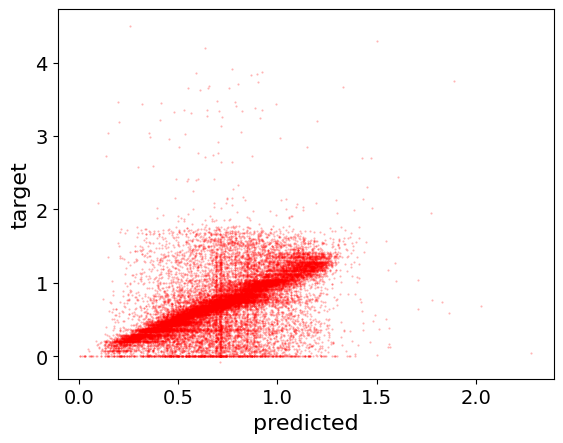

In [14]:
plt.plot(ypred, target, 'r.', alpha = 0.3, markersize = 1)
plt.xlabel('predicted')
plt.ylabel('target')
plt.show()

4. It's also interesting to look at the distribution of the predicted values. Plot histograms of both predicted and true values. Any observations?

 -**predicted values appear to be squished (predicted redshifts are closer to the gaussian mean)**

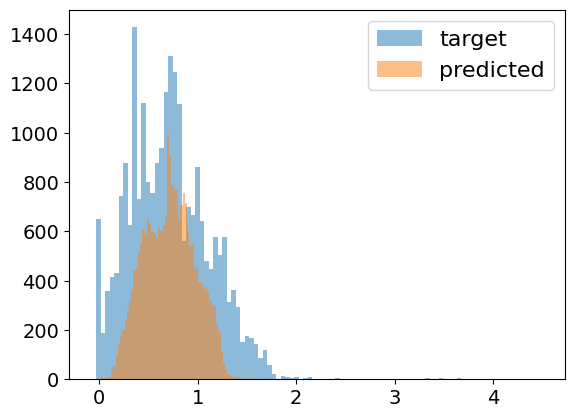

In [15]:

counts, bins = np.histogram(target, bins = 100)
plt.hist(bins[:-1], bins, weights=counts, label = 'target', alpha = 0.5)
counts, bins = np.histogram(ypred, bins = 100)
plt.hist(bins[:-1], bins, weights=counts, label = 'predicted', alpha = 0.5)
plt.legend()
plt.show()

5. Calculate the outlier fraction $\eta$ defined at the beginning, does it compare to the data from the paper?

$$\eta =\frac{z_{true} - z_{est}}{1+z_{true}} > 0.15 $$

the value 

In [16]:
### Is this the right way?

outlier_frac = len(target[np.abs(target - ypred)/(1 + ypred) > 0.15])/len(target)

print('outlier fraction: {}'.format(outlier_frac))

outlier fraction: 0.2596759298127781


## Step 3: Parameter Optimization.

1. We can start by making the data set a bit smaller, as we have seen that timings were already challenging in simple k-fold CV. Generate a smaller sample of 5000 examples. They should be drawn randomly without replacement from the full dataset, try *np.random.choice*

In [17]:
np.random.seed(0) # for reproducability
indices = np.random.choice(range(len(df.index)), size = 5000, replace = False)
features_small = features.iloc[indices]
target_small = target.iloc[indices]

2. It is good practice to ensure that the performance on the smaller set remains similar to the one obtained on the entire data set, which means that the change in size will not significantly affect the optimization process. So run the 3-fold crossvalidation again on the smaller dataset

**roughly the same results**

In [18]:
#2
cv = KFold(n_splits=3, shuffle=True)
results = cross_validate(model, features_small, target_small, cv=cv, n_jobs = -1, return_train_score = True)
print('test score: mean = {:.3f}, std = {:.4f}'.format(results['test_score'].mean() , results['test_score'].std()))
print('train score: mean = {:.3f}, std = {:.4f}'.format(results['train_score'].mean() , results['train_score'].std()))

test score: mean = 0.216, std = 0.0311
train score: mean = 0.861, std = 0.0088


3. We are now ready to optimize hyperparameters. Here are some options:

#### Tree Parameters

Some useful parameters associated to a tree are:

-  The minimum number of instances in a leaf node;

-  The minimum number of instances required in a split node;

- The maximum depth of tree;

-  The criterion chosen to decide whether a split is "worth it", expressed in terms of information gain.


#### Randomization Parameters

Here we find:

- The number of k < n features that are used in building trees;

- The re-sampling (boostrap) of the data set (T or F).


#### Forest Parameters

The number of trees in the forest (n_estimators) can be adjusted, with the general understanding that more trees are better, but at some point performance will plateau, so one can find the trade-off between having more trees and lower runtime.

Try running grid search to look for the best model within the following parameter subset. Are you able to improve the model significantly?

**the model did not improve significantly**

- min_impurity_decrease: 0, 0.1, 0.5  

- max_leaf_nodes: None, 100, 200

- min_samples_split: 10, 20, 100

- max_features: None, 2, 4

In [19]:
parameters = {'min_impurity_decrease':[0, 0.1, 0.5], 'max_leaf_nodes': [None, 100, 200],\
              'min_samples_split':[10, 20, 100], 'max_features':[None, 2, 4]}

grid_model = GridSearchCV(model, parameters, cv = cv, verbose = 2, n_jobs = -1)

grid_model.fit(features_small, target_small)

print('Best params, best score:', "{:.4f}".format(grid_model.best_score_), grid_model.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best params, best score: 0.2531 {'max_features': 2, 'max_leaf_nodes': None, 'min_impurity_decrease': 0, 'min_samples_split': 10}


4. In addition to hyperparameter optimization, another possibility for improving the model could be to consider additional features that might help the decision trees. 

We need to retain some additional columns to be used in the selection process. Try adding *'subaru_source','cfhtls_source','zquality'* to the already existing six features.

In [20]:
mags = df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','subaru_source','cfhtls_source','zquality']]
print(mags.shape)
print(target.shape)

(23822, 9)
(23822,)


There are a few more clean-up steps that help in the process. Finding these constitutes many hours of research work, but here we take a shortcut and benefit from the knowledge of the authors of the redshift paper.

a) only use objects with high-quality spectroscopic redshift measurements, zquality>3

b) select objects with cfhtls deep photometric data, cfhtls_source = 0 

In [21]:
#a)
mags_clean = mags.loc[mags['zquality'] >= 3]
target_clean = target.loc[mags['zquality'] >= 3]
print(mags_clean.shape)
print(target_clean.shape)

#b)
mags_clean = mags_clean.loc[mags['cfhtls_source'] == 0]
target_clean = target_clean.loc[mags['cfhtls_source'] == 0]
print(mags_clean.shape)
print(target_clean.shape)

(16857, 9)
(16857,)
(10671, 9)
(10671,)


c) Unavailable measurements are marked by -99 or 99 (while typical values are around 20-25). We also get rid of data with missing measurements.

In [22]:
columns = ['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor','subaru_source','cfhtls_source','zquality']

for column in columns:
    indices = mags_clean[column] != 99
    mags_clean = mags_clean.loc[indices]
    target_clean = target_clean.loc[indices]
    
    indices = mags_clean[column] != -99
    mags_clean = mags_clean.loc[indices]
    target_clean = target_clean.loc[indices]
    
print(mags_clean.shape)
print(target_clean.shape)

(6307, 9)
(6307,)


Now that we have curated this extended data set with the additional information, we only keep the six original features in this dataset in our final dataset that should have 6,307 objects. We need, of course, to select the same set on the target vector.

In [23]:
features_clean = mags_clean[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor','y_apercor']]

5. Evaluate this new benchmark model via cross-validation. Note that for reproducible results we need to fix the random\_state=5 parameter of the Random Forest (which controls the bootstrap process) and the random_state=10 of the cross validation.

Find the new mean test and train scores, has the model improved?

**-significantly improved!**

In [24]:
model = RandomForestRegressor(random_state = 5)
cv = KFold(n_splits=3, shuffle=True, random_state = 10)
results = cross_validate(model, features_clean, target_clean, cv=cv, n_jobs = -1, return_train_score = True)
print('test score: mean = {:.3f}, std = {:.4f}'.format(results['test_score'].mean() , results['test_score'].std()))
print('train score: mean = {:.3f}, std = {:.4f}'.format(results['train_score'].mean() ,results['train_score'].std()))

test score: mean = 0.738, std = 0.0681
train score: mean = 0.964, std = 0.0051


We can re-run the optimization process (note that the data set size is limited, so we don't need to make it smaller), but let's skip this for now in the interest of time.

Finally, we can generate one set of predictions to visualize what happens. Plot again observed values against predictions. Any improvement? Also compute the outlier fraction. 

 **- improved data! outlier fraction alot smaller :)**

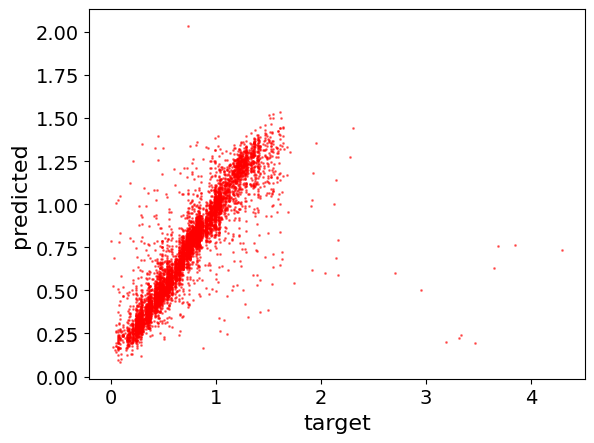

outlier fraction: 0.05359124781988267


In [25]:
ypred_clean = cross_val_predict(model, features_clean, target_clean, cv=cv)
plt.plot(target_clean, ypred_clean, 'r.', alpha = 0.5, markersize = 2)
plt.ylabel('predicted')
plt.xlabel('target')
plt.show()

outlier_frac = len(target_clean[np.abs(target_clean - ypred_clean)/(1 + ypred_clean) > 0.15])/len(target_clean)

print('outlier fraction: {}'.format(outlier_frac))

## Step 4: Boosting Methods

Now that we have explored random forests, let's take a look at the boosting strategy.

In [26]:
from sklearn.ensemble import AdaBoostRegressor

1. First, set up the AdaBoostRegressor with the default parameters, compute cross-validated prediction and make a scatter plot of predictions versus true values. Also check out the default parameters via .get_params(). Any comments? 

**- AdaBoostRegressor performed poorly** 

In [27]:
model = AdaBoostRegressor()
ypred_ada = cross_val_predict(model, features_clean, target_clean, cv=cv)
model.get_params()

{'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

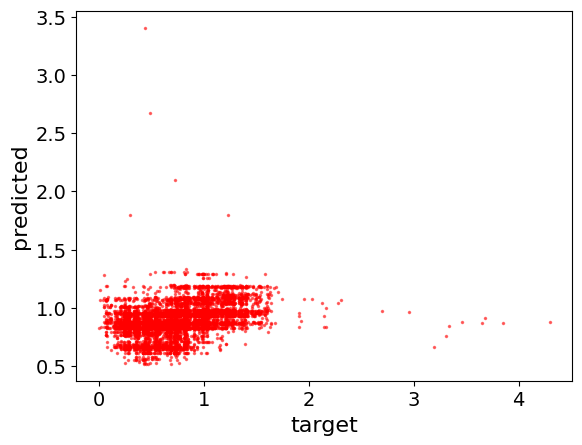

In [28]:
plt.plot(target_clean, ypred_ada, 'r.', alpha = 0.5, markersize = 3)
plt.ylabel('predicted')
plt.xlabel('target')
plt.show()

2. The AdaBoostRegressor has a nice property called "staged_predict" that lets one examine how the prediction gradually improves with stacking at each stage. Create a train/test split (test_size=0.3) because we need to use the ".fit" method in order to access the "staged_predict" property later.

Initialize AdaBoostRegressor with **estimator=DecisionTreeRegressor(max_depth=3),n_estimators=30**, fit the AdaBoostRegressor to the training set, then use the staged_predict property to make a plot of R2-score versus iteration for up to the 30 estimators.

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(features_clean, target_clean, test_size=0.3, random_state=42)
model = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 3), n_estimators = 30)
model.fit(X_train, y_train)
y_preds = model.staged_predict(X_test)
r2s = [r2_score(y_test, y_pred) for y_pred in y_preds]

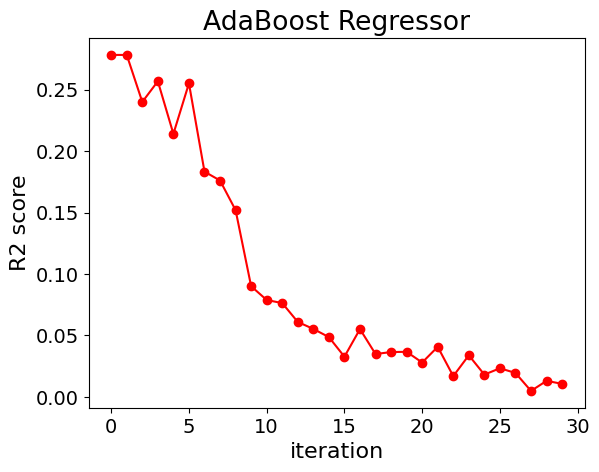

In [30]:
plt.plot(np.arange(len(r2s)), r2s, 'ro-')
plt.xlabel('iteration')
plt.ylabel('R2 score')
plt.title("AdaBoost Regressor")
plt.show()

3. The default estimator in AdaBoost is a decision tree with max_depth=3. Repeat the above calculation with a stronger base learner, i.e. max_depth=6 and max_depth=10 and combine all three curves in one graph. Any comments?

 **more depth resulted in better r2 scores!. The number of iterations did not have much positive affect in scores after the first few, infact the smallest depth produced worse scores with each extra iteration**

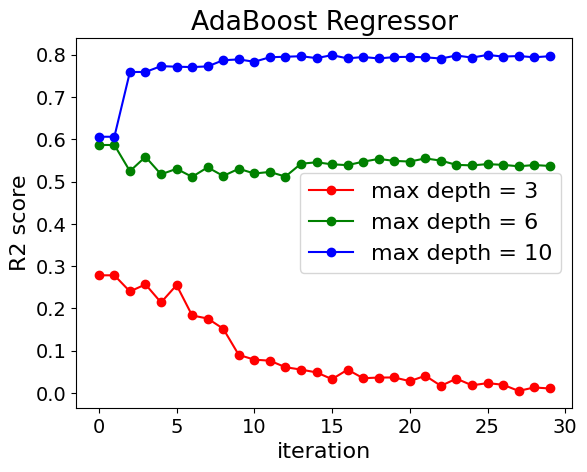

In [31]:
model = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 6), n_estimators = 30)
model.fit(X_train, y_train)
y_preds = model.staged_predict(X_test)
r2s_6 = [r2_score(y_test, y_pred) for y_pred in y_preds]

model = AdaBoostRegressor(estimator = DecisionTreeRegressor(max_depth = 10), n_estimators = 30)
model.fit(X_train, y_train)
y_preds = model.staged_predict(X_test)
r2s_10 = [r2_score(y_test, y_pred) for y_pred in y_preds]

plt.plot(np.arange(len(r2s)), r2s, 'ro-', label = 'max depth = 3')
plt.plot(np.arange(len(r2s_6)), r2s_6, 'go-', label = 'max depth = 6')
plt.plot(np.arange(len(r2s_10)), r2s_10, 'bo-', label = 'max depth = 10')
plt.xlabel('iteration')
plt.ylabel('R2 score')
plt.title("AdaBoost Regressor")
plt.legend()
plt.show()

4. Now try out GradientBoostingRegressor and produce the same plot with this alternative method. Any comments?

- **more depth did not necessarily produce better r2 scores, (depth = 6, 10 are similiar). but the number of iterations raised their r2 score significantly.**

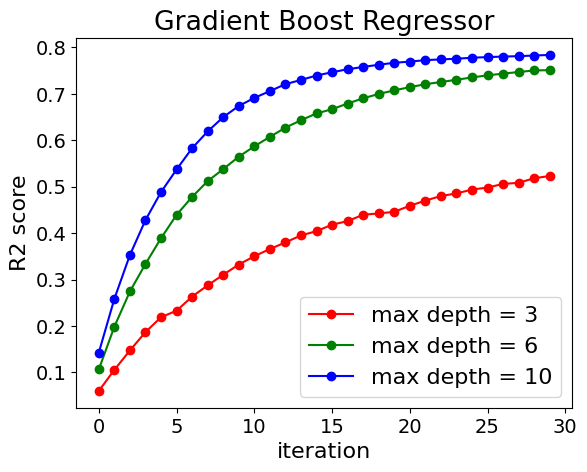

[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0, min_samples_split=10; total time=   1.7s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0, min_samples_split=100; total time=   1.1s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0.1, min_samples_split=20; total time=   0.2s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0.5, min_samples_split=10; total time=   0.2s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0, min_samples_split=10; total time=   1.5s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0.1, min_samples_split=10; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0.1, min_samples_split=100; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0.5, min_samples_split=100; total time=   0.2s
[CV] END max_features=2, max_leaf_nodes=None, min_impurity_decrease=0, min

[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0, min_samples_split=100; total time=   1.2s
[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_split=10; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_split=10; total time=   0.2s
[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_split=20; total time=   0.2s
[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.1, min_samples_split=100; total time=   0.2s
[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.5, min_samples_split=10; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.5, min_samples_split=100; total time=   0.2s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0, min_samples_split=20; total time=   1.3s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decre

[CV] END max_features=None, max_leaf_nodes=None, min_impurity_decrease=0, min_samples_split=20; total time=   1.5s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0, min_samples_split=20; total time=   1.2s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0.1, min_samples_split=20; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0.5, min_samples_split=10; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=100, min_impurity_decrease=0.5, min_samples_split=100; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0, min_samples_split=100; total time=   1.1s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0.1, min_samples_split=10; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0.1, min_samples_split=100; total time=   0.3s
[CV] END max_features=None, max_leaf_nodes=200, min_impurity_decrease=0.5,

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth = 3, n_estimators = 30)
model.fit(X_train, y_train)
y_preds = model.staged_predict(X_test)
r2s = [r2_score(y_test, y_pred) for y_pred in y_preds]

model = GradientBoostingRegressor(max_depth = 6, n_estimators = 30)
model.fit(X_train, y_train)
y_preds = model.staged_predict(X_test)
r2s_6 = [r2_score(y_test, y_pred) for y_pred in y_preds]

model = GradientBoostingRegressor(max_depth = 10, n_estimators = 30)
model.fit(X_train, y_train)
y_preds = model.staged_predict(X_test)
r2s_10 = [r2_score(y_test, y_pred) for y_pred in y_preds]

plt.plot(np.arange(len(r2s)), r2s, 'ro-', label = 'max depth = 3')
plt.plot(np.arange(len(r2s_6)), r2s_6, 'go-', label = 'max depth = 6')
plt.plot(np.arange(len(r2s_10)), r2s_10, 'bo-', label = 'max depth = 10')
plt.xlabel('iteration')
plt.ylabel('R2 score')
plt.title("Gradient Boost Regressor")
plt.legend()
plt.show()